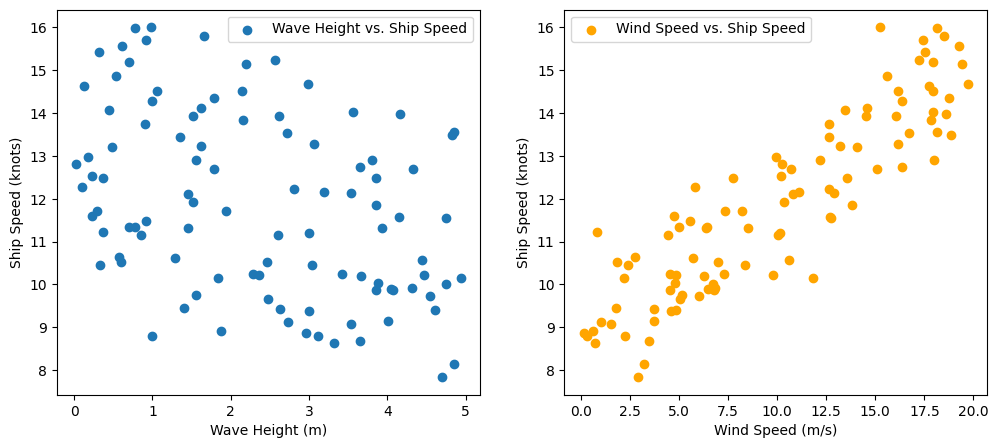

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(42)
n_samples = 100
h = np.random.uniform(0, 5, n_samples)  # Wave height (meters)
w = np.random.uniform(0, 20, n_samples)  # Wind speed (m/s)
u = 10 - 0.5 * h + 0.3 * w  # Ship speed (knots)

# Add some noise to simulate real-world conditions
u += np.random.normal(0, 0.5, n_samples)

# Convert h and w to TensorFlow tensors
h_tensor = tf.convert_to_tensor(h, dtype=tf.float32)
w_tensor = tf.convert_to_tensor(w, dtype=tf.float32)


# Plot the data
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(h, u, label='Wave Height vs. Ship Speed')
ax[0].set_xlabel('Wave Height (m)')
ax[0].set_ylabel('Ship Speed (knots)')
ax[0].legend()

ax[1].scatter(w, u, label='Wind Speed vs. Ship Speed', color='orange')
ax[1].set_xlabel('Wind Speed (m/s)')
ax[1].set_ylabel('Ship Speed (knots)')
ax[1].legend()

plt.show()

In [6]:
# Define the PINN model
def build_pinn_model():
    inputs = tf.keras.Input(shape=(2,))
    x = layers.Dense(10, activation='tanh')(inputs)
    x = layers.Dense(10, activation='tanh')(x)
    outputs = layers.Dense(1)(x)
    model = models.Model(inputs, outputs)
    return model

# Instantiate the model
model = build_pinn_model()

# Define the custom loss function
def pinn_loss(y_true, y_pred, h, w):
    # Data loss
    data_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    # Physics loss
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([h, w])
        u_pred = model(tf.stack([h, w], axis=1))
    du_dh = tape.gradient(u_pred, h)
    du_dw = tape.gradient(u_pred, w)

    physics_loss = tf.reduce_mean(tf.square(du_dh + 0.5)) + tf.reduce_mean(tf.square(du_dw - 0.3))

    # Total loss
    total_loss = data_loss + physics_loss
    return total_loss


In [7]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss=lambda y_true, y_pred: pinn_loss(y_true, y_pred, h_tensor, w_tensor))

# Train the model
history = model.fit(np.stack([h, w], axis=1), u, epochs=500, verbose=0)



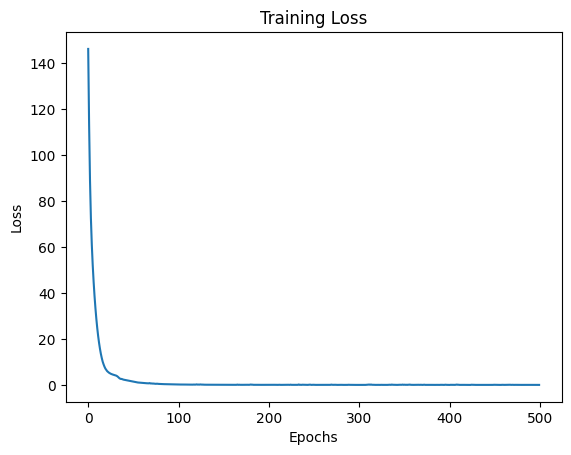

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


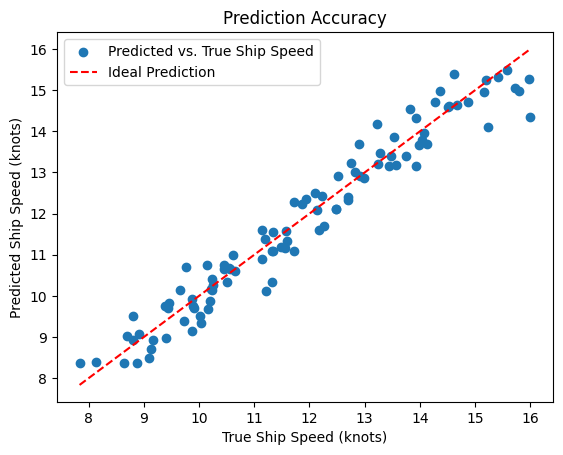

In [10]:
# Plot training performance
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Predict using the trained model
u_pred = model.predict(np.stack([h, w], axis=1))

# Plot prediction accuracy
plt.scatter(u, u_pred, label='Predicted vs. True Ship Speed')
plt.plot([min(u), max(u)], [min(u), max(u)], 'r--', label='Ideal Prediction')
plt.xlabel('True Ship Speed (knots)')
plt.ylabel('Predicted Ship Speed (knots)')
plt.legend()
plt.title('Prediction Accuracy')
plt.show()